### Identification of Siezure activity in a EEG data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Some useful functions for next class:

# detect the outliers
# return a list
def detect_outliers(data):
    outliers_inds = []
    q1 = np.quantile(data, 0.25)
    q3 = np.quantile(data, 0.75)
    iqr = q3 - q1  # Interquartile range
    fence_low = q1 - 1.5 * iqr
    fence_high = q3 + 1.5 * iqr
    for ind, value in enumerate(data):
        if value > fence_high or value < fence_low:
            outliers_inds.append(ind)
    return outliers_inds


# Z score normalize
def normalize(data):
    mean = np.average(data, axis=0)
    std = np.std(data, axis=0)
    data = (data - mean) / std
    return data


# max-min normalize
def normalize2(data):
    min = np.min(data)
    max = np.max(data)
    data = (data - min) / (max - min)
    return data


Imported data and Plotting the SpecGram

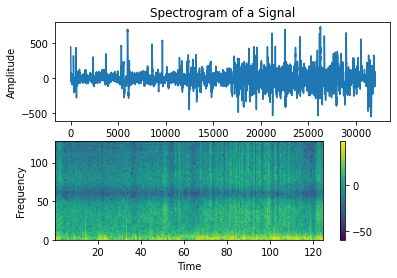

In [ ]:
import scipy.io as scio
from scipy.signal import welch, get_window
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations
from prettytable import PrettyTable
import matplotlib.pyplot as plot
import pandas as pd

# please enter the address of input file "session4_train_2018.mat"
path = r'/content/gdrive/MyDrive/BOM24_2390_AI/Assignment-1/session4_train_2018.mat'  # PATH TO THE FILE
data = scio.loadmat(path)

raw = data['EEG'][0][0][0][0]   # EXPERIMENT WITH THIS

plot.subplot(211)
plot.title('Spectrogram of a Signal')

signal = pd.DataFrame(raw)
DF = pd.DataFrame({
    'S': signal.iloc[:,0]
})
plot.plot(DF.S)
plot.xlabel('Sample')
plot.ylabel('Amplitude')

samplingFrequency = data['EEG'][0][0][4][0][0]  #- fix this path!

# Compute and plot a spectrogram of data in x. Data are split into NFFT length segments and the spectrum of each section is computed. 
# The windowing function window is applied to each segment, and the amount of overlap of each segment is specified with noverlap. The spectrogram is plotted as a colormap (using imshow).
plot.subplot(212)
plot.specgram(DF.S,Fs=samplingFrequency,NFFT=samplingFrequency, noverlap=(samplingFrequency/2))
plot.xlabel('Time')
plot.ylabel('Frequency')

plot.colorbar()
plot.show()

In [ ]:
#Write the result to a file:
DF.to_csv("session4_train_2018.csv", index=None)

In [ ]:
(DF.shape[0]-1)/256

125.0

The following does the frequency analysis for the session*2018.mat file, equivalent to what we did in Matlab.

In [ ]:
# 61 for non-seizure; 61 for seizure
segments = [[] for _ in range(122)]

# Estimate the power spectral density for each EEG segment using the pwelch function and compute the relative power in the delta (1- 4Hz), theta (4-7Hz), alpha (7-12Hz) and beta (12-20Hz) band. 
# The relative power is the ratio of the power in a specific frequency band to the total power of the signal (use the trapz function to compute the area under the PSD). 

# Process the first 61 secs

label = 0

fs = data['EEG'][0][0][4][0][0] 
window = get_window('hamming', fs)
nfft = fs #256
step = fs // nfft
_iter = []
# delete the data from 61 to 63s
if label == 0:
    _iter = range(61)
else:
    _iter = range(61, 122)

for i in _iter:
    if label == 0:  # last one(from 60 to 62)
        freq, psd = welch(raw[i * 256:(i + 2) * 256], window=window, fs=fs, nfft=nfft)
    else:  # first one (62 to 64)   last one(from 122 to 124)
        freq, psd = welch(raw[(i + 1) * 256:(i + 3) * 256], window=window, fs=fs, nfft=nfft)

    total_energy = np.trapz(psd, freq)
    # extraction of powers for different frequency bands
    segments[i].append(np.trapz(psd[1:4 + step], range(1, 4 + step, step)) / total_energy)
    segments[i].append(np.trapz(psd[4:7 + step], range(4, 7 + step, step)) / total_energy)
    segments[i].append(np.trapz(psd[7:12 + step], range(7, 12 + step, step)) / total_energy)
    segments[i].append(np.trapz(psd[12:20 + step], range(12, 20 + step, step)) / total_energy)
    segments[i].append(label)


# Process the next 61 secs
label = 1

window = get_window('hamming', 256)
fs = data['EEG'][0][0][4][0][0] 
nfft = fs #256
step = fs // nfft
_iter = []
# delete the data from 61 to 63s
if label == 0:
    _iter = range(61)
else:
    _iter = range(61, 122)

for i in _iter:
    if label == 0:  # last one(from 60 to 62)
        freq, psd = welch(raw[i * 256:(i + 2) * 256], window=window, fs=fs, nfft=nfft)
    else:  # first one (62 to 64)   last one(from 122 to 124)
        freq, psd = welch(raw[(i + 1) * 256:(i + 3) * 256], window=window, fs=fs, nfft=nfft)

    total_energy = np.trapz(psd, freq)
    # extraction of powers for different frequency bands
    segments[i].append(np.trapz(psd[1:4 + step], range(1, 4 + step, step)) / total_energy)
    segments[i].append(np.trapz(psd[4:7 + step], range(4, 7 + step, step)) / total_energy)
    segments[i].append(np.trapz(psd[7:12 + step], range(7, 12 + step, step)) / total_energy)
    segments[i].append(np.trapz(psd[12:20 + step], range(12, 20 + step, step)) / total_energy)
    segments[i].append(label)

segments = np.array(segments)

# Normalize the signal data (not the ground truth labels!)
segments[:, 0:4] = normalize(segments[:, 0:4])

segments = pd.DataFrame(segments)

segments.columns = ['delta', 'theta', 'alpha', 'beta', 'seizure']
segments.seizure = segments.seizure.astype('category')
segments.head()

print(segments.info(verbose=True))

print(segments.seizure.value_counts())


In [ ]:
total_energy

35153.018108829856

In [ ]:
np.size(total_energy)

1

2 sec Moving Window Data

In [ ]:
segments['StartTime'] = range(0,len(segments))
segments['EndTime'] = range((0+2),(len(segments)+2))
segments.head()
segments.to_csv("/content/session4_train_2018_features_2secMovingWindow.csv")

In [ ]:
# segments.shape
print(segments)

        delta     theta     alpha      beta seizure  StartTime  EndTime
0    0.078163 -0.862881 -0.338840 -0.337928     0.0          0        2
1    0.494690 -0.553793 -0.326905 -0.443843     0.0          1        3
2    0.602692 -0.666739 -0.360776 -0.150565     0.0          2        4
3   -1.688642  1.245915  1.610830  2.200395     0.0          3        5
4   -1.352890  2.009183  1.725683  0.644332     0.0          4        6
..        ...       ...       ...       ...     ...        ...      ...
117  0.209423 -0.468595 -0.815475 -0.603714     1.0        117      119
118  0.358654 -0.772287 -0.879625 -0.795594     1.0        118      120
119  0.736515 -0.464151 -0.473446  0.004803     1.0        119      121
120  0.136875 -0.035818 -0.739820 -0.657882     1.0        120      122
121  0.221773  0.363664 -0.857693 -0.818914     1.0        121      123

[122 rows x 7 columns]


Segmnted the data and Processing

In [ ]:
segments['StartTime'] = segments['StartTime'].astype('float64')
segments['EndTime'] = segments['EndTime'].astype('float64')
print(segments.info(verbose=True))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122 entries, 0 to 121
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   delta      122 non-null    float64 
 1   theta      122 non-null    float64 
 2   alpha      122 non-null    float64 
 3   beta       122 non-null    float64 
 4   seizure    122 non-null    category
 5   StartTime  122 non-null    float64 
 6   EndTime    122 non-null    float64 
dtypes: category(1), float64(6)
memory usage: 6.1 KB
None


In [ ]:
segments.to_csv("/content/session4_train_2018_features_2secMovingWindow.csv", index=None)

In [ ]:
delta = segments['delta']
beta = segments['beta']
alpha = segments['alpha']
theta = segments['theta']

# trials = delta, beta,alp

In [ ]:
segments.shape

(122, 7)

Scatter Plot of Seizure Vs Normal Activity (Delta Features)

Text(0.5, 1.0, 'Delta Features of Seizure and Normal')

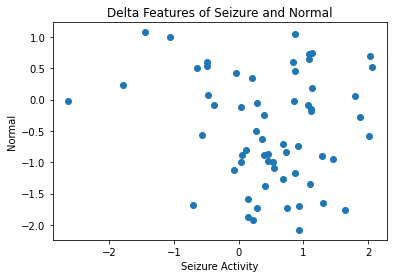

In [ ]:
plt.scatter(delta[61:124],delta[0:61])
plt.xlabel('Seizure Activity')
plt.ylabel('Normal')
plt.title('Delta Features of Seizure and Normal')

Scatter Plot of Seizure Vs Normal Activity (Theta Features)

Text(0.5, 1.0, 'Theta Features of Seizure and Normal')

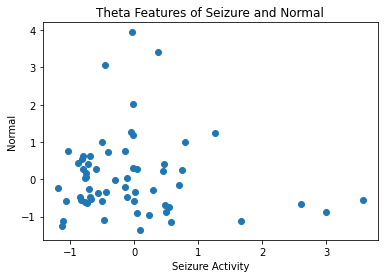

In [ ]:
plt.scatter(theta[61:124],theta[0:61])
plt.xlabel('Seizure Activity')
plt.ylabel('Normal')
plt.title('Theta Features of Seizure and Normal')

Scatter Plot of Seizure Vs Normal Activity (Alpha Features)

Text(0.5, 1.0, 'Alpha Features of Seizure and Normal')

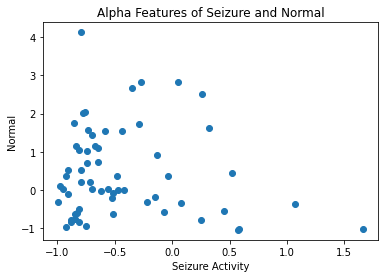

In [ ]:
plt.scatter(alpha[61:124],alpha[0:61])
plt.xlabel('Seizure Activity')
plt.ylabel('Normal')
plt.title('Alpha Features of Seizure and Normal')

Scatter Plot of Seizure Vs Normal Activity (Beta Features)

Text(0.5, 1.0, 'Beta Features of Seizure and Normal')

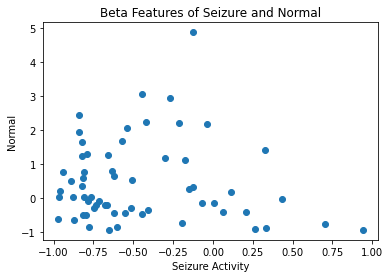

In [ ]:
plt.scatter(beta[61:124],beta[0:61])
plt.xlabel('Seizure Activity')
plt.ylabel('Normal')
plt.title('Beta Features of Seizure and Normal')

In [ ]:
segments['StartTime']

0        0.0
1        1.0
2        2.0
3        3.0
4        4.0
       ...  
117    117.0
118    118.0
119    119.0
120    120.0
121    121.0
Name: StartTime, Length: 122, dtype: float64

Statistics and Printing Seizure Activity Values

In [ ]:
Mean_Delta_Seizure = np.mean(delta[62:124]);
Mean_Theta_Seizure = np.mean(theta[62:124]);
Mean_Alpha_Seizure = np.mean(alpha[62:124]);
Mean_Beta_Seizure = np.mean(beta[62:124]);



std_Delta_Seizure = np.std(delta[62:124]); 
std_Theta_Seizure = np.std(theta[62:124]);
std_Alpha_Seizure = np.std(alpha[62:124]); 
std_Beta_Seizure = np.std(beta[62:124]); 

 

print('Mean Values of Different Frequency in Seizure class')
print('Mean of Delta', Mean_Delta_Seizure)
print('Mean of Beta', Mean_Theta_Seizure)
print('Mean of Alpha', Mean_Alpha_Seizure)
print('Mean of Theta', Mean_Beta_Seizure)

print('Standard Deviation of Different Frequency in Seizure class')
print('Standard Deviation of Delta', std_Delta_Seizure)
print('Standard Deviation of Beta', std_Theta_Seizure)
print('Standard Deviation of Alpha', std_Alpha_Seizure)
print('Standard Deviation of Theta', std_Beta_Seizure)




Mean Values of Different Frequency in Seizure class
Mean of Delta 0.48724201122395494
Mean of Beta -0.12162378417311447
Mean of Alpha -0.4476899009116994
Mean of Theta -0.45605481374321954
Standard Deviation of Different Frequency in Seizure class
Standard Deviation of Delta 0.8989534734022788
Standard Deviation of Beta 0.8583282447190532
Standard Deviation of Alpha 0.5416799160582731
Standard Deviation of Theta 0.44360925285684366


Statistics and Printing Seizure Normal Values

In [ ]:
Mean_Delta_Normal = np.mean(delta[0:61]);
Mean_Beta_Normal = np.mean(delta[0:61]);
Mean_Alpha_Normal = np.mean(alpha[0:61]);
Mean_Theta_Normal = np.mean(theta[0:61]);

Std_Delta_Normal = np.std(delta[0:61]); 
Std_Beta_Normal = np.std(beta[0:61]); 
Std_Alpha_Normal = np.std(alpha[0:61]); 
Std_Theta_Normal = np.std(theta[0:61]); 

print('Mean Values of Different Frequency in Normal Class')
print('Mean of Delta', Mean_Delta_Normal)
print('Mean of Beta', Mean_Beta_Normal)
print('Mean of Alpha', Mean_Alpha_Normal)
print('Mean of Theta', Mean_Theta_Normal)

print('Standard Deviation of Different Frequency in Normal Class')
print('Standard Deviation of Delta', Std_Delta_Normal)
print('Standard Deviation of Beta', Std_Beta_Normal)
print('Standard Deviation of Alpha', Std_Alpha_Normal)
print('Standard Deviation of Theta', Std_Theta_Normal)




Mean Values of Different Frequency in Normal Class
Mean of Delta -0.471408145039687
Mean of Beta -0.471408145039687
Mean of Alpha 0.43915520608226155
Mean of Theta 0.07041869983448538
Standard Deviation of Different Frequency in Normal Class
Standard Deviation of Delta 0.8635024727840921
Standard Deviation of Beta 1.1797849287808442
Standard Deviation of Alpha 1.1494815937804708
Standard Deviation of Theta 1.052670364349255


Frequency Bands

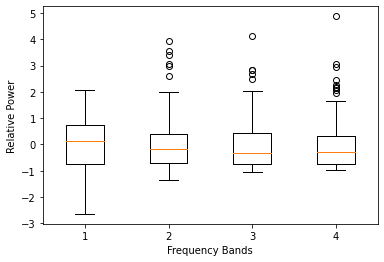

In [ ]:
import matplotlib.pyplot as plt


segPlot = segments.T;
plt.boxplot(segPlot[0:4]);
plt.xlabel('Frequency Bands');
plt.ylabel('Relative Power');


ttest of of Delta, Beta, Alpha, Theta & Raw Data wave - Feature

In [ ]:
import scipy.io 
from scipy import stats

summary, results1 = scipy.stats.ttest_ind(delta[0:61], delta[62:124], axis=0, equal_var=False)
print('ttest of Delta feature:', summary,results1)

summary2, results2 = scipy.stats.ttest_ind(beta[0:61], beta[62:124], axis=0, equal_var=False)
print('ttest of Beta feature:', summary2,results2)

summary3, results3 = scipy.stats.ttest_ind(alpha[0:61], alpha[62:124], axis=0, equal_var=False)
print('ttest of Alpha feature:', summary3,results3)

summary4, results4 = scipy.stats.ttest_ind(theta[0:61], theta[62:124], axis=0, equal_var=False)
print('ttest of Theta feature:', summary4,results4)

summary5, results5 = scipy.stats.ttest_ind(raw[0:(61*256)], raw[(62*256):(124*256)], axis=0, equal_var=False)
print('ttest of Raw Data', summary5,results5)



ttest of Delta feature: -5.931148770465669 3.041531930859938e-08
ttest of Beta feature: 5.594554980692244 3.2548684134975617e-07
ttest of Alpha feature: 5.397670189428897 5.921401366934148e-07
ttest of Theta feature: 1.0915119618126983 0.2773278565073152
ttest of Raw Data 1.0552953018959357 0.29130021040965437


Wilcoxon Test of Delta, Beta, Alpha, Theta wave - Feature

In [ ]:
stat, p = scipy.stats.wilcoxon(delta[0:61], delta[61:124], zero_method='wilcox')
print('Wilcoxon test of Delta feature:', stat, p)

stat1, p1 = scipy.stats.wilcoxon(beta[0:61], beta[61:124], zero_method='wilcox')
print('Wilcoxon test of Beta feature:', stat1, p1)

stat2, p2 = scipy.stats.wilcoxon(alpha[0:61], alpha[61:124], zero_method='wilcox')
print('Wilcoxon test of Alpha feature:', stat, p2)

stat3, p3 = scipy.stats.wilcoxon(theta[0:61], theta[61:124], zero_method='wilcox')
print('Wilcoxon test of Theta feature:', stat, p3)



Wilcoxon test of Delta feature: 317.0 6.350391140943032e-06
Wilcoxon test of Beta feature: 287.0 2.2467717673520646e-06
Wilcoxon test of Alpha feature: 317.0 5.003189659560552e-06
Wilcoxon test of Theta feature: 317.0 0.1757513047285525


Mann Whitney Test of Delta, Beta, Alpha, Theta wave - Feature

In [ ]:
manstat, manp = scipy.stats.mannwhitneyu(delta[0:61], delta[62:124], use_continuity=True, alternative='two-sided')
print('Mann Whitney test of Delta feature:', manstat, manp)

manstat1, manp1 = scipy.stats.mannwhitneyu(beta[0:61], beta[62:124], use_continuity=True, alternative='two-sided')
print('Mann Whitney test of Beta feature:', manstat1, manp1)

manstat2, manp2 = scipy.stats.mannwhitneyu(alpha[0:61], alpha[62:124], use_continuity=True, alternative='two-sided')
print('Mann Whitney test of Alpha feature:', manstat, manp2)

manstat3, manp3 = scipy.stats.mannwhitneyu(theta[0:61], theta[62:124], use_continuity=True, alternative='two-sided')
print('Mann Whitney test of Theta feature:', manstat, manp3)

manstat, manp = scipy.stats.mannwhitneyu(raw[0:(61*256)], raw[(62*256):(124*256)], use_continuity=True, alternative='two-sided')
print('Mann Whitney test of Raw Data:', manstat, manp)

Mann Whitney test of Delta feature: 771.0 4.0805590281179664e-08
Mann Whitney test of Beta feature: 2801.0 4.875924952386369e-07
Mann Whitney test of Alpha feature: 771.0 2.4805722340807712e-06
Mann Whitney test of Theta feature: 771.0 0.3059050936158646
Mann Whitney test of Raw Data: 124879732.5 0.23823718299286412


The Mann-Whitney U test is the nonparametric equivalent of the two sample t-test. Wilcoxon is also a rank based test, both are used to measure two independent samples, whereas the average only measures centre of distribution. 


When the window size increases there is possibility of losing features. We predict that when window size increases with overlap, say form 2sec to 4 sec and more.. There are more chances for classifier misconceptions and losing the feature. As a result miscalculated probability distribution is possible. 